# Problem Statement 

I am choosing this topic as I have heard a lot of people suffering from mental health issues some even commit suicide due to Covid 19 pandemic and would like to understand any trends across countries for suicide rate. The data that is quite easy to understand and neatly grouped so I thought it would make analysis and deriving insight clearer than some of the other sets on populations that are available publicly. 

In this project, I would like to 
* explore the relationship between suicide rate and other variables by some visualizations. 
* use Machine Learning algorithms to predict suicide rates. 
* compare which model performs better.

# Dataset Description 
I searched for suicide rate data set in Kaggle and found a complied dataset which was pulled from four other datasets linked by time and place. It contains **27,820 records and 12 columns**, including country, year, sex, age group, count of suicides, population, suicide rate, country-year composite key, HDI（Human Development Index） for year, gdp_for_year, gdp_per_capita, generation (based on age grouping average).


The data chosen provides many dimensions and measures along which to conduct analysis such as population of each country each year, further broken down into population of different age groups. The GDP per capita is also available, along with Gender.

## Limitations
* Not all countries provided data
* Just 3 countries in Africa provided data
* Some large population country (eg. China, India, Indonesia, etc.) didn’t provide data

**data source: https://www.kaggle.com/russellyates88/suicide-rates-overview-1985-to-2016**

# Data cleaning 
- ## Load datasets

In [2]:
# import necesary libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pycountry
import pycountry_convert as pc
import seaborn as sns
from statistics import mean
from colour import Color
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

# read file
suicide_rate = pd.read_csv(
    "/Users/yiling/Desktop/COMP-4254-0 - Adv Topics Data Analytics /Project/Suicide Rates Overview 1985 to 2016.csv")

In [3]:
# the first five rows of the dataset
suicide_rate.head()

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,"2,156,624,900",796,Boomers


In [4]:
# get basic dataframe information
suicide_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27820 entries, 0 to 27819
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   country             27820 non-null  object 
 1   year                27820 non-null  int64  
 2   sex                 27820 non-null  object 
 3   age                 27820 non-null  object 
 4   suicides_no         27820 non-null  int64  
 5   population          27820 non-null  int64  
 6   suicides/100k pop   27820 non-null  float64
 7   country-year        27820 non-null  object 
 8   HDI for year        8364 non-null   float64
 9    gdp_for_year ($)   27820 non-null  object 
 10  gdp_per_capita ($)  27820 non-null  int64  
 11  generation          27820 non-null  object 
dtypes: float64(2), int64(4), object(6)
memory usage: 2.5+ MB


**Insight**
* A lot of values are missing in **HDI for year** from the basic info. Notice that **gdp_for_year ($)** is **object type** by default which should be **numeric**. 

- ## Standardize the column name

**Insight**
* **Column names are not standardized. One of them uses spaces to connect two words. And one of them uses "-" to connect two words.**

In [5]:
# standardize the column name
suicide_rate.columns = [c.strip() for c in suicide_rate.columns]
suicide_rate.columns = [c.replace(' ', '_') for c in suicide_rate.columns]
suicide_rate.columns = [c.replace('-', '_') for c in suicide_rate.columns]

- ## Tidy Age column

**Insight**
* **Remove the string 'years' to make the age column more concise. And replace '5-14' to '05-14' to make the age column can be arranged in order.**

In [6]:
suicide_rate['age'] = suicide_rate['age'].str.replace('years', '')
suicide_rate['age'] = suicide_rate['age'].str.replace('5-14', '05-14')

suicide_rate.head(5)

,country,year,sex,age,suicides_no,population,suicides/100k_pop,country_year,HDI_for_year,gdp_for_year_($),gdp_per_capita_($),generation
0,Albania,1987,male,15-24,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24,14,289700,4.83,Albania1987,NaN,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+,1,21800,4.59,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34,9,274300,3.28,Albania1987,NaN,"2,156,624,900",796,Boomers


- ## Remove HDI_for_year and country_year columns

In [7]:
# check if there is any missing value.
suicide_rate.isnull().any()

country               False
year                  False
sex                   False
age                   False
suicides_no           False
population            False
suicides/100k_pop     False
country_year          False
HDI_for_year           True
gdp_for_year_($)      False
gdp_per_capita_($)    False
generation            False
dtype: bool

In [8]:
# sum the missing value
suicide_rate.isnull().sum()

country                   0
year                      0
sex                       0
age                       0
suicides_no               0
population                0
suicides/100k_pop         0
country_year              0
HDI_for_year          19456
gdp_for_year_($)          0
gdp_per_capita_($)        0
generation                0
dtype: int64

**Insight**
* There are a lot missing values in the **HDI_for_year** column. **It should be dropped**. And notice that **country_year** is a **composite column** as we already have country and year these two columns. **So drop country_year column as well**. 

In [9]:
# drop the HDI for year column and contry-year column
suicide_rate = suicide_rate.drop(['HDI_for_year', 'country_year'], axis=1)

- ## Convert gdp_for_year_($) column to float type

**Insight**
* **Since gdp_for_year_($) column is object type by default which should be numeric. So change it to float type**.

In [10]:
# convert gdp_for_year_($) to float
suicide_rate['gdp_for_year_($)'] = suicide_rate['gdp_for_year_($)'].str.replace(
    ',', '')
suicide_rate['gdp_for_year_($)'] = suicide_rate['gdp_for_year_($)'].astype(
    float)

In [11]:
# the first 5 rows of new dataframe
suicide_rate.head()

,country,year,sex,age,suicides_no,population,suicides/100k_pop,gdp_for_year_($),gdp_per_capita_($),generation
0,Albania,1987,male,15-24,21,312900,6.71,2.156625e+09,796,Generation X
1,Albania,1987,male,35-54,16,308000,5.19,2.156625e+09,796,Silent
2,Albania,1987,female,15-24,14,289700,4.83,2.156625e+09,796,Generation X
3,Albania,1987,male,75+,1,21800,4.59,2.156625e+09,796,G.I. Generation
4,Albania,1987,male,25-34,9,274300,3.28,2.156625e+09,796,Boomers


- ## Remove 2016 data

In [12]:
# get total records by year
records_by_year = suicide_rate.groupby('year')['country']\
    .count().reset_index().rename(columns={'country': 'Total records'})
print(records_by_year)

    year  Total records
0   1985            576
1   1986            576
2   1987            648
3   1988            588
4   1989            624
5   1990            768
6   1991            768
7   1992            780
8   1993            780
9   1994            816
10  1995            936
11  1996            924
12  1997            924
13  1998            948
14  1999            996
15  2000           1032
16  2001           1056
17  2002           1032
18  2003           1032
19  2004           1008
20  2005           1008
21  2006           1020
22  2007           1032
23  2008           1020
24  2009           1068
25  2010           1056
26  2011           1032
27  2012            972
28  2013            960
29  2014            936
30  2015            744
31  2016            160


In [13]:
# get the unique countries in 2016
unique_country_2016 = suicide_rate[suicide_rate['year']
                                   == 2016].country.unique()
print(unique_country_2016)

['Armenia' 'Austria' 'Croatia' 'Cyprus' 'Czech Republic' 'Grenada'
 'Hungary' 'Iceland' 'Lithuania' 'Mauritius' 'Mongolia' 'Netherlands'
 'Qatar' 'Romania' 'Sweden' 'Thailand']


In [14]:
# the count of unique country in 2016
len(unique_country_2016)

16

**Insight**
* **There are few records and few countries in the year 2016. So I am gonna filter out the 2016 data**.

In [15]:
# filter out the 2016 data
suicide_rate = suicide_rate[suicide_rate['year'] != 2016]
print("\n*** the first 5 rows of filtered dataframe***")
suicide_rate.head()


*** the first 5 rows of filtered dataframe***


,country,year,sex,age,suicides_no,population,suicides/100k_pop,gdp_for_year_($),gdp_per_capita_($),generation
0,Albania,1987,male,15-24,21,312900,6.71,2.156625e+09,796,Generation X
1,Albania,1987,male,35-54,16,308000,5.19,2.156625e+09,796,Silent
2,Albania,1987,female,15-24,14,289700,4.83,2.156625e+09,796,Generation X
3,Albania,1987,male,75+,1,21800,4.59,2.156625e+09,796,G.I. Generation
4,Albania,1987,male,25-34,9,274300,3.28,2.156625e+09,796,Boomers


In [16]:
# generate descriptive statistics
suicide_rate.describe()

,year,suicides_no,population,suicides/100k_pop,gdp_for_year_($),gdp_per_capita_($)
count,27660.000000,27660.000000,2.766000e+04,27660.000000,2.766000e+04,27660.000000
mean,2001.173102,243.413485,1.850689e+06,12.812597,4.471009e+11,16815.568330
std,8.418754,904.490185,3.920658e+06,18.972063,1.457574e+12,18861.585497
min,1985.000000,0.000000,2.780000e+02,0.000000,4.691962e+07,251.000000
25%,1994.000000,3.000000,9.753525e+04,0.910000,8.976208e+09,3436.000000
50%,2002.000000,25.000000,4.307250e+05,5.980000,4.801361e+10,9283.000000
75%,2008.000000,132.000000,1.491041e+06,16.602500,2.602024e+11,24796.000000
max,2015.000000,22338.000000,4.380521e+07,224.970000,1.812071e+13,126352.000000


- ## Add continent column

**Insight**
* First, find out which countries in this dataframe don't have corresponding name in pycountry package then fix the names of the above countries to match the country names in pycountry package. At last, write a function to convert to alpah2 country codes and continents

In [17]:
countries = {}
for country in pycountry.countries:
    countries[country.name] = country.alpha_3

In [18]:
country_not_in_list = list(
    set([i for i in suicide_rate.country if i not in countries.keys()]))
country_not_in_list

['Saint Vincent and Grenadines',
 'Czech Republic',
 'Republic of Korea',
 'Macau']

In [19]:
# fix the names of the above countries to match the country names in pycountry package
suicide_rate = suicide_rate.replace('Republic of Korea', 'South Korea')
suicide_rate = suicide_rate.replace(
    'Saint Vincent and Grenadines', 'Saint Vincent and the Grenadines')
suicide_rate = suicide_rate.replace('Czech Republic', "Czechia")
suicide_rate = suicide_rate.replace('Macau', 'Macao')

In [20]:
# function to convert to alpah2 country codes and continents

def country_to_continent(country_name):

    country_alpha2 = pc.country_name_to_country_alpha2(country_name)
    country_continent_code = pc.country_alpha2_to_continent_code(
        country_alpha2)
    country_continent_name = pc.convert_continent_code_to_continent_name(
        country_continent_code)
    return country_continent_name


continent = []
for i in suicide_rate['country']:
    c = country_to_continent(i)
    continent.append(c)

# add continent colum
suicide_rate['continent'] = continent

In [21]:
# the first 5 rows of new dataframe
suicide_rate.head()

,country,year,sex,age,suicides_no,population,suicides/100k_pop,gdp_for_year_($),gdp_per_capita_($),generation,continent
0,Albania,1987,male,15-24,21,312900,6.71,2.156625e+09,796,Generation X,Europe
1,Albania,1987,male,35-54,16,308000,5.19,2.156625e+09,796,Silent,Europe
2,Albania,1987,female,15-24,14,289700,4.83,2.156625e+09,796,Generation X,Europe
3,Albania,1987,male,75+,1,21800,4.59,2.156625e+09,796,G.I. Generation,Europe
4,Albania,1987,male,25-34,9,274300,3.28,2.156625e+09,796,Boomers,Europe


In [22]:
# get the unique value of continent
suicide_rate.continent.unique()

array(['Europe', 'North America', 'South America', 'Asia', 'Oceania',
       'Africa'], dtype=object)

In [23]:
suicide_rate = suicide_rate.dropna()
suicide_rate.shape

(27660, 11)

# Exploratory analysis 
- ## Worldwide Analysis Of Suicide Rate 
- ### Worldwide Analysis Of Suicide Rate Over Time 

In [24]:
# calculate worldwide average suicide rate per year
suicide_rate_by_year = suicide_rate.groupby('year')['suicides/100k_pop']\
    .mean().reset_index().rename(columns={'suicides/100k_pop': 'average_suicide_rate'})
print(suicide_rate_by_year)
mean_suicide_rate = mean(suicide_rate_by_year['average_suicide_rate'])
print("\n")
print("the average of the global suicide rate is ", round(mean_suicide_rate, 3))

    year  average_suicide_rate
0   1985             11.826198
1   1986             11.423333
2   1987             11.644213
3   1988             12.709405
4   1989             12.879071
5   1990             12.862956
6   1991             13.438880
7   1992             13.498564
8   1993             13.833705
9   1994             14.073272
10  1995             15.662671
11  1996             15.305422
12  1997             14.954361
13  1998             14.926920
14  1999             14.532038
15  2000             13.941328
16  2001             13.519138
17  2002             13.786550
18  2003             13.205019
19  2004             12.481944
20  2005             12.068442
21  2006             11.927461
22  2007             12.025339
23  2008             11.907686
24  2009             11.400787
25  2010             11.215900
26  2011             11.015349
27  2012             11.421718
28  2013             11.107958
29  2014             11.011464
30  2015             11.094073


the av

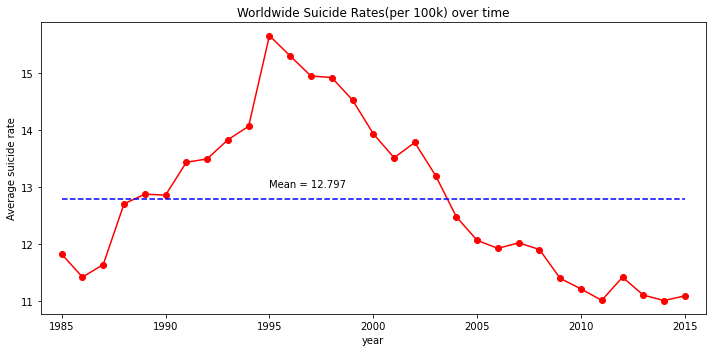

In [25]:
fig = plt.subplots(figsize=(10, 5))
plt.plot('year', 'average_suicide_rate', 'ro-', data=suicide_rate_by_year)
plt.plot(np.linspace(1985, 2015, 31), np.linspace(
    mean_suicide_rate, mean_suicide_rate, 31), 'b--')
plt.xlim(1984, 2016)
plt.xlabel('year')
plt.ylabel('Average suicide rate')
plt.text(1995, 13, r'Mean = 12.797')
plt.title('Worldwide Suicide Rates(per 100k) over time')
plt.tight_layout()
plt.show()

**Insights**
- The rate peaked in **1995** , and began to decrease after that year

- ### Worldwide Suicide Rate By Gender

In [26]:
# calculate average suicide rate by gender
suicide_rate_gender = suicide_rate.groupby('sex')['suicides/100k_pop']\
    .mean().reset_index().rename(columns={'suicides/100k_pop': 'average_suicide_rate'})
print(suicide_rate_gender)
print("\n")

# calculate average suicide rate by gender by year
suicide_rate_men = suicide_rate[suicide_rate.sex == "male"].groupby('year')['suicides/100k_pop']\
    .mean().reset_index().rename(columns={'suicides/100k_pop': 'Male_average_suicide_rate'})
suicide_rate_women = suicide_rate[suicide_rate.sex == "female"].groupby('year')['suicides/100k_pop']\
    .mean().reset_index().rename(columns={'suicides/100k_pop': 'Female_average_suicide_rate'})
print(suicide_rate_men)
print("\n")
print(suicide_rate_women)

      sex  average_suicide_rate
0  female              5.396188
1    male             20.229007


    year  Male_average_suicide_rate
0   1985                  17.875486
1   1986                  17.033993
2   1987                  17.556296
3   1988                  19.095408
4   1989                  19.581314
5   1990                  19.818906
6   1991                  20.849792
7   1992                  20.747462
8   1993                  21.636154
9   1994                  21.906520
10  1995                  24.905256
11  1996                  24.296472
12  1997                  23.903983
13  1998                  23.774198
14  1999                  23.196305
15  2000                  22.099651
16  2001                  21.546345
17  2002                  21.966996
18  2003                  21.107655
19  2004                  19.909762
20  2005                  19.129286
21  2006                  19.085863
22  2007                  19.056667
23  2008                  18.835961
24

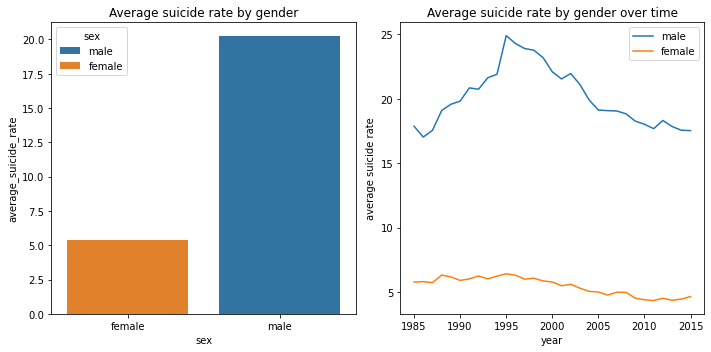

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].set_title('Average suicide rate by gender')
sns.barplot(ax=axes[0], x='sex', y='average_suicide_rate', hue='sex', hue_order=[
            'male', 'female'], dodge=False, data=suicide_rate_gender)
sns.lineplot(ax=axes[1], x='year', y='Male_average_suicide_rate',
             markers=True, data=suicide_rate_men,  ci=None)
sns.lineplot(ax=axes[1], x='year', y='Female_average_suicide_rate',
             markers=True, data=suicide_rate_women, ci=None)
axes[1].legend(["male", 'female'])
axes[1].set(xlabel='year', ylabel='average suicide rate')
axes[1].set_title("Average suicide rate by gender over time")
plt.tight_layout()

**Insights**
* Globally, the rate of suicide for **men has been 3.7x higher than women** from 1985 to 2015.
* Both male & female suicide rates **peaked in 1995**, declining since then.
* Worldwide **male** suicide rate peaked in **1995** with 24.91, which has **increased 39.34%** from the
first year.
* Worldwide **female** suicide rate peaked in **1995** with 6.42, which has **increased 11.13%** from the first year.
* **In 2015**, worldwide **male** suicide rate was **17.53**. It means around 18 deaths per 100,000 men in 2015.
* **In 2015**, worldwide **female** suicide rate was **4.65**. It means around 5 deaths per 100,000 women in 2015. 

- ### Worldwide Suicide Rate By Age

In [28]:
# calculate average suicide rate by age
suicide_rate_age = suicide_rate.groupby('age')['suicides/100k_pop']\
    .mean().reset_index().rename(columns={'suicides/100k_pop': 'average_suicide_rate'})

print(suicide_rate_age)

      age  average_suicide_rate
0  05-14               0.620041
1  15-24               8.957182
2  25-34              12.199479
3  35-54              14.958887
4  55-74              16.163380
5    75+              23.976614


In [29]:
# calculate average suicide rate by age by year
suicide_rate_age_year = suicide_rate.groupby(['year', 'age'])['suicides/100k_pop']\
    .mean().reset_index().rename(columns={'suicides/100k_pop': 'average_suicide_rate'})

print(suicide_rate_age_year)

     year     age  average_suicide_rate
0    1985  05-14               0.537083
1    1985  15-24               8.429688
2    1985  25-34              10.008750
3    1985  35-54              12.403021
4    1985  55-74              15.094375
..    ...     ...                   ...
181  2015  15-24               7.773226
182  2015  25-34              10.111774
183  2015  35-54              12.555645
184  2015  55-74              14.451774
185  2015    75+              20.967339

[186 rows x 3 columns]


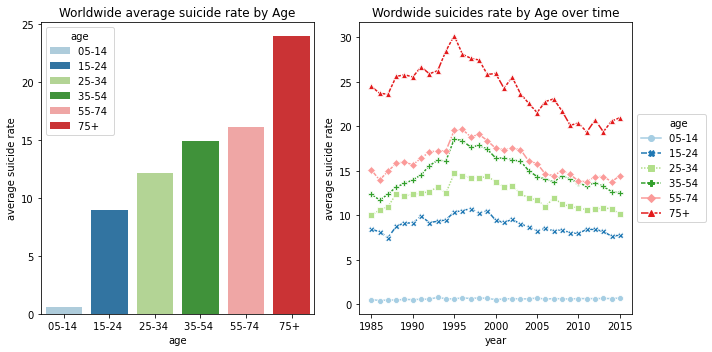

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].set_title('Worldwide average suicide rate by Age')
sns.barplot(ax=axes[0], x='age', y='average_suicide_rate',
            hue='age', palette='Paired', dodge=False,  data=suicide_rate_age)
axes[0].set(xlabel='age', ylabel='average suicide rate')
sns.lineplot(ax=axes[1], x='year', y='average_suicide_rate', hue='age',
             palette='Paired', style='age', markers=True, data=suicide_rate_age_year,  ci=None)
axes[1].set(xlabel='year', ylabel='average suicide rate')
axes[1].set_title("Wordwide suicides rate by Age over time")
axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

**Insight**
* **75+** age group has the **highest** suicide rate globally.
* **75+** age group **peaked around 1995**, declining since then.
* **suicide rate increases as age increases**.

- ## By continent
- ### Suicide Rate By Continent

In [31]:
# calculate the average suicide rate by continent
suicide_rate_by_continent = suicide_rate.groupby('continent')['suicides/100k_pop']\
    .mean().reset_index().rename(columns={'suicides/100k_pop': 'average_suicide_rate'})
continent_sorted = suicide_rate_by_continent.sort_values(
    'average_suicide_rate', ascending=True)
print(continent_sorted)

       continent  average_suicide_rate
3  North America              7.371629
0         Africa              7.555131
1           Asia             10.960335
5  South America             11.428745
4        Oceania             11.561831
2         Europe             17.469470


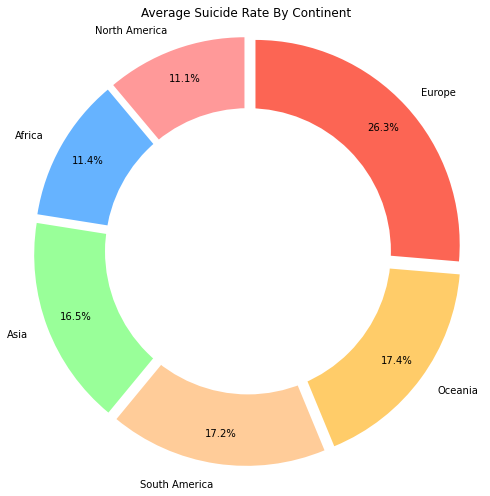

In [32]:
# Reference:https://medium.com/@kvnamipara/a-better-visualisation-of-pie-charts-by-matplotlib-935b7667d77f
fig, ax = plt.subplots(figsize=(7, 7))
ax.set_title('Average Suicide Rate By Continent')
# Pie chart
labels = continent_sorted.continent
sizes = continent_sorted.average_suicide_rate
# colors
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#ffcc69', '#fc6554']
# explsion
explode = (0.05, 0.05, 0.05, 0.05, 0.05, 0.05)
plt.pie(sizes, colors=colors, labels=labels, autopct='%1.1f%%',
        startangle=90, pctdistance=0.85, explode=explode)
# draw circle
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax.axis('equal')
plt.tight_layout()

**Insight**
* **Europe** is the **highest** suicide rate continent. 
* **North America** is the **lowest** suicide rate continent.

- ### Suicide Rate By Continent Over Time

In [33]:
# calculate the average suicide rate by continent by year
suicide_rate_by_continent_year = suicide_rate.groupby(['continent', 'year'])['suicides/100k_pop']\
    .mean().reset_index().rename(columns={'suicides/100k_pop': 'average_suicide_rate'})
print(suicide_rate_by_continent_year)
print("\n")
print("**** The average suicide rate of each continent in 2015")
print(suicide_rate_by_continent_year[suicide_rate_by_continent_year['year'] == 2015])

         continent  year  average_suicide_rate
0           Africa  1985             12.471250
1           Africa  1986              2.222083
2           Africa  1987              9.694167
3           Africa  1988             20.509167
4           Africa  1989             17.636667
..             ...   ...                   ...
181  South America  2011             13.067396
182  South America  2012             15.219907
183  South America  2013             13.013148
184  South America  2014             11.798125
185  South America  2015             10.764861

[186 rows x 3 columns]


**** The average suicide rate of each continent in 2015
         continent  year  average_suicide_rate
30          Africa  2015              5.395000
61            Asia  2015              9.251667
92          Europe  2015             14.364911
123  North America  2015              6.520076
154        Oceania  2015             12.848333
185  South America  2015             10.764861


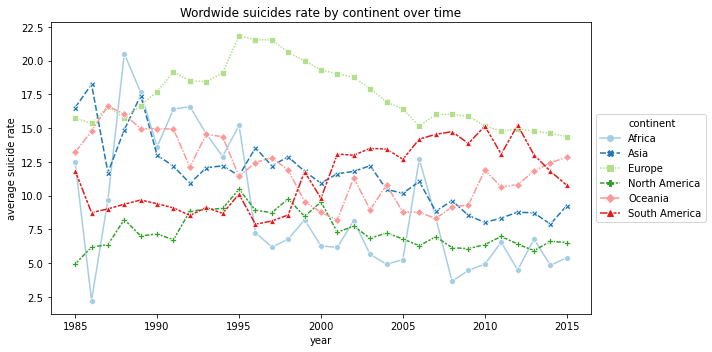

In [34]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(x='year', y='average_suicide_rate', hue='continent', palette='Paired',
             style='continent', markers=True, data=suicide_rate_by_continent_year,  ci=None)
ax.set(xlabel='year', ylabel='average suicide rate')
ax.set_title("Wordwide suicides rate by continent over time")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

**Insight**
- **Europe** has the **highest** suicide rate overall but since **1995 it steadily decrease**. 
- In **2015**, **Europe** suicide rate is similar to **Oceania and South America**.

- ### Suicide Rate By Continent And Gender

In [35]:
# Calculate suicide rate by continent by gender
suicide_rate_men_continent = suicide_rate[suicide_rate.sex == "male"].groupby('continent')['suicides/100k_pop']\
    .mean().reset_index().rename(columns={'suicides/100k_pop': 'Male_average_suicide_rate'})
suicide_rate_women_continent = suicide_rate[suicide_rate.sex == "female"].groupby('continent')['suicides/100k_pop']\
    .mean().reset_index().rename(columns={'suicides/100k_pop': 'Female_average_suicide_rate'})
print(suicide_rate_men_continent)
print("\n")
print(suicide_rate_women_continent)

       continent  Male_average_suicide_rate
0         Africa                  12.063167
1           Asia                  16.116825
2         Europe                  27.735697
3  North America                  12.248158
4        Oceania                  18.243107
5  South America                  18.290583


       continent  Female_average_suicide_rate
0         Africa                     3.047095
1           Asia                     5.803845
2         Europe                     7.203243
3  North America                     2.495099
4        Oceania                     4.880556
5  South America                     4.566907


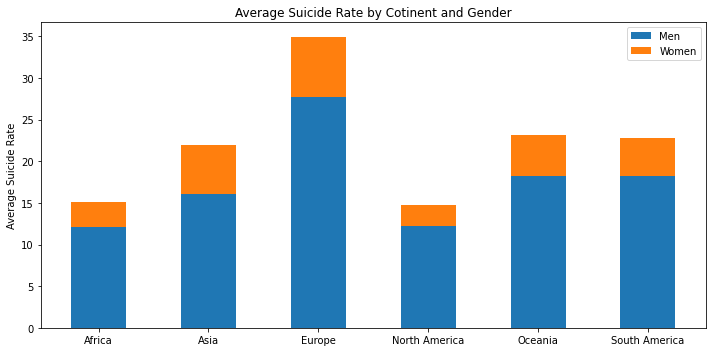

In [36]:
N = 6
ind = np.arange(N)    # the x locations for the groups
width = 0.5       # the width of the bars: can also be len(x) sequence
womenMeans = suicide_rate_women_continent.Female_average_suicide_rate
menMeans = suicide_rate_men_continent.Male_average_suicide_rate
plt.subplots(figsize=(10, 5))
p1 = plt.bar(ind, menMeans, width)
p2 = plt.bar(ind, womenMeans, width,
             bottom=menMeans)

plt.ylabel('Average Suicide Rate')
plt.title('Average Suicide Rate by Cotinent and Gender')
plt.xticks(ind, ('Africa', 'Asia', 'Europe',
                 'North America', 'Oceania', 'South America'))

plt.legend((p1[0], p2[0]), ('Men', 'Women'))
plt.tight_layout()
plt.show()

**Insight**
* **European** were at the **highest risk** between 1985 and 2015
* **North America** was at the **lowest risk** between 1985 and 2015
* **Male** had **higher** suicides rate than **female in All continents** between 1985 and 2015.

- ### Suicide Rate By Continent And Age

In [37]:
# calculate average suicide rate by continent and age
suicide_rate_age_continent = suicide_rate.groupby(['continent', 'age'])['suicides/100k_pop']\
    .mean().reset_index().rename(columns={'suicides/100k_pop': 'average_suicide_rate'})

print(suicide_rate_age_continent)

        continent     age  average_suicide_rate
0          Africa  05-14               0.598714
1          Africa  15-24               7.852214
2          Africa  25-34              10.107071
3          Africa  35-54              10.532857
4          Africa  55-74               7.331071
5          Africa    75+               8.908857
6            Asia  05-14               0.626772
7            Asia  15-24               7.749571
8            Asia  25-34              10.609819
9            Asia  35-54              11.729616
10           Asia  55-74              13.458318
11           Asia    75+              21.587912
12         Europe  05-14               0.567595
13         Europe  15-24              10.026186
14         Europe  25-34              15.016531
15         Europe  35-54              21.122733
16         Europe  55-74              23.319809
17         Europe    75+              34.763967
18  North America  05-14               0.467877
19  North America  15-24               6

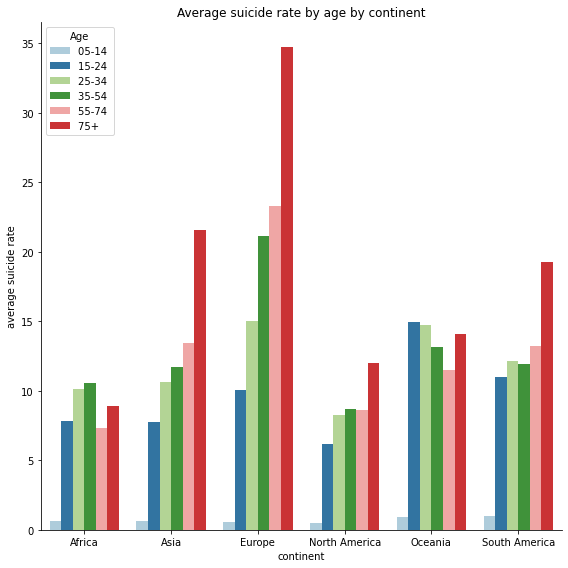

In [38]:
# Draw a nested barplot by species and sex
g = sns.catplot(
    data=suicide_rate_age_continent, kind="bar",
    x='continent', y='average_suicide_rate', hue='age',
    ci="sd", palette="Paired", height=8, legend=False
)
g.set_axis_labels('continent', 'average suicide rate')
plt.legend(title='Age', loc=2)
plt.title("Average suicide rate by age by continent")
plt.tight_layout()
plt.show()

**Insights**
* For **Europe, Asia**, suicide rate **increases as age increases.**
*  **75+ age group European have the highest suicide rate.**

- ## By country
- ### Top 10 Country With Highest Suicide Rate

In [39]:
# top 10 countries have highest suicide rate
top_10_country = suicide_rate.groupby('country')['suicides/100k_pop']\
    .mean().reset_index().rename(columns={'suicides/100k_pop': 'average_suicide_rate'})\
    .sort_values('average_suicide_rate',  ascending=False).head(10)

print("*** top 10 country with highest suicide rate***")
print(top_10_country)
print("\n")

top_10_country_2015 = suicide_rate[suicide_rate['year'] == 2015].groupby('country')['suicides/100k_pop']\
    .mean().reset_index().rename(columns={'suicides/100k_pop': 'average_suicide_rate'})\
    .sort_values('average_suicide_rate',  ascending=False).head(10)
print("*** top 10 country with highest suicide rate in 2015***")
print(top_10_country_2015)

*** top 10 country with highest suicide rate***
               country  average_suicide_rate
52           Lithuania             40.583968
86           Sri Lanka             35.295152
73  Russian Federation             34.892377
40             Hungary             33.049100
11             Belarus             31.075913
47          Kazakhstan             30.511282
51              Latvia             29.259325
82            Slovenia             27.827857
30             Estonia             27.276905
94             Ukraine             26.582321


*** top 10 country with highest suicide rate in 2015***
               country  average_suicide_rate
51         South Korea             32.428333
31           Lithuania             32.123333
61             Uruguay             22.501667
49            Slovenia             22.067500
23             Hungary             21.439167
30              Latvia             20.955833
58             Ukraine             20.393333
28          Kazakhstan             19.8

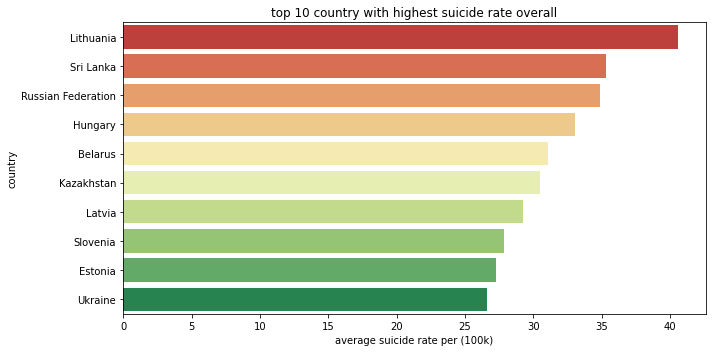

In [40]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x="average_suicide_rate", y="country",
            data=top_10_country, palette="RdYlGn", orient='h')
ax.set(xlabel='average suicide rate per (100k)', ylabel='country')
ax.set_title("top 10 country with highest suicide rate overall")
plt.tight_layout()

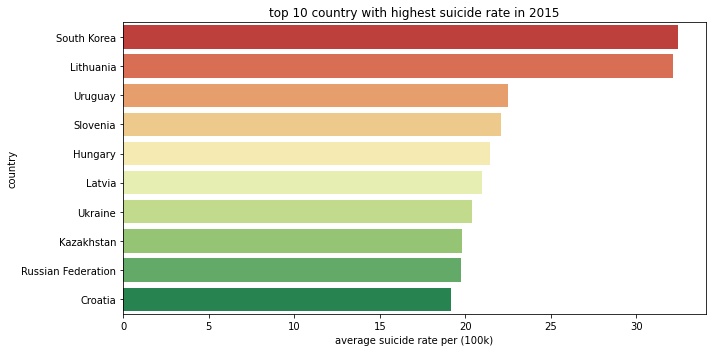

In [41]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x="average_suicide_rate", y="country",
            data=top_10_country_2015, palette="RdYlGn", orient='h')
ax.set(xlabel='average suicide rate per (100k)', ylabel='country')
plt.title("top 10 country with highest suicide rate in 2015")
plt.tight_layout()

**Insights**

* **Lithuania has the highest suicide rate overall but in 2015 it moved to second place**. 
* **South Korea has the highest suicide rate in 2015** 

- ### Suicide Rate By Gender in TOP 10 highest suicide rate countries

In [42]:
# get the top 10 highest suicide rate countries
countries = []
for country in top_10_country.country:
    countries.append(country)

In [43]:
# calculate the suicide rate by gender in TOP 10 highest suicide rate countries
country_gender = suicide_rate[suicide_rate['country'].isin(countries)].groupby(['country', 'sex'])['suicides/100k_pop']\
    .mean().reset_index().rename(columns={'suicides/100k_pop': 'average_suicide_rate'})\
    .sort_values('average_suicide_rate',  ascending=False)
print(country_gender)

               country     sex  average_suicide_rate
11           Lithuania    male             68.136667
13  Russian Federation    male             58.183704
17           Sri Lanka    male             55.091667
1              Belarus    male             52.757619
5              Hungary    male             51.864600
7           Kazakhstan    male             50.014038
9               Latvia    male             48.775873
15            Slovenia    male             45.174206
3              Estonia    male             45.056984
19             Ukraine    male             44.253393
16           Sri Lanka  female             15.498636
4              Hungary  female             14.233600
10           Lithuania  female             13.031270
12  Russian Federation  female             11.601049
6           Kazakhstan  female             11.008526
14            Slovenia  female             10.481508
8               Latvia  female              9.742778
2              Estonia  female              9.

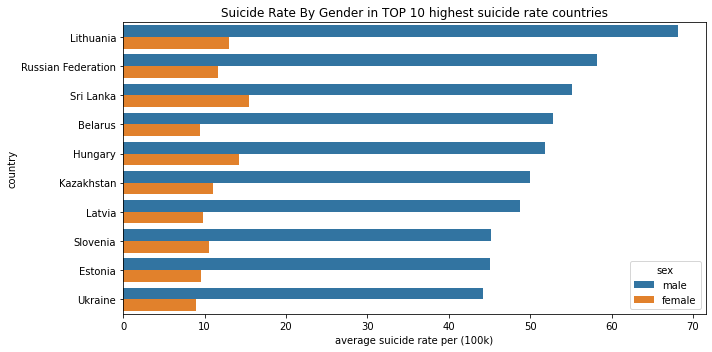

In [44]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x="average_suicide_rate", y="country",
            data=country_gender, hue='sex', orient='h')
ax.set(xlabel='average suicide rate per (100k)', ylabel='country')
plt.title("Suicide Rate By Gender in TOP 10 highest suicide rate countries")
plt.tight_layout()

**Insight**
* In TOP 10 highest suicide rate countries, **male suicide rate is much higher than female**.

- ### Suicide Rate By Age In TOP 10 Highest Suicide Rate Countries

In [45]:
#calculate suicide rate by age in TOP 10 highest suicide rate countries
country_age = suicide_rate[suicide_rate['country'].isin(countries)].groupby(['country', 'age'])['suicides/100k_pop']\
    .mean().reset_index().rename(columns={'suicides/100k_pop': 'average_suicide_rate'})\
    .sort_values('average_suicide_rate',  ascending=False)

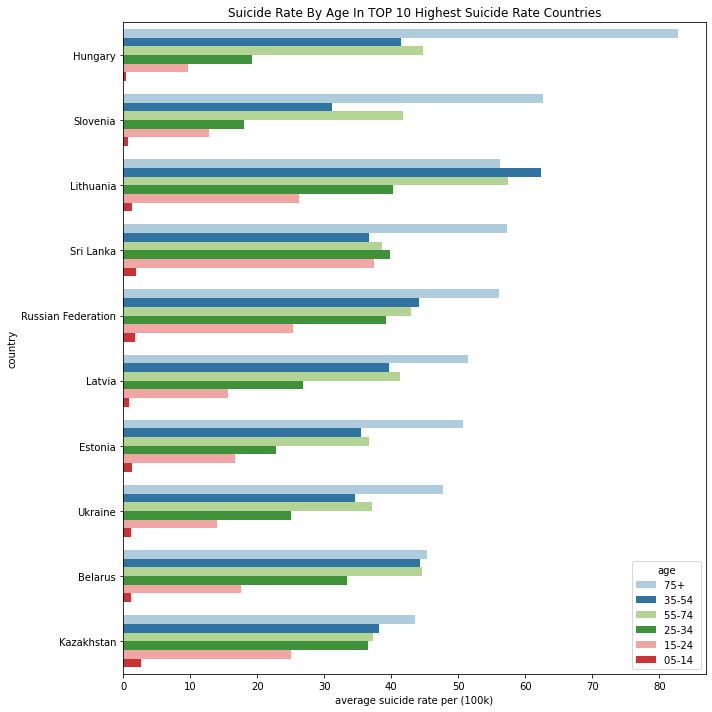

In [46]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.barplot(x="average_suicide_rate", y="country",
            data=country_age, hue='age', palette='Paired', orient='h')
ax.set(xlabel='average suicide rate per (100k)', ylabel='country')
plt.title("Suicide Rate By Age In TOP 10 Highest Suicide Rate Countries")
plt.tight_layout()

**Insight**
* **75+ age group have the highest suicide rate in all top 10 highest suicide rate countries except Lithuania**.
* **In Lithuania, 35-54 age group have the highest suicide rate**. 
* **In hungary, 75+ age group have the highest suicide rate**. 

- ## Correlation between GDP Per Capita and Suicide Rate

In [47]:
# calculate GDP Per Capital by continent
gdp_continent = suicide_rate.groupby(['continent', 'country'])['gdp_per_capita_($)']\
    .mean().reset_index().rename(columns={'gdp_per_capita_($)': 'average gdp per captita'})

# calculate suicide rate by continent and country
suicide_rate_continent_country = suicide_rate.groupby(['continent', 'country'])['suicides/100k_pop']\
    .mean().reset_index().rename(columns={'suicides/100k_pop': 'average suicide rate'})

# merge two dataframes
gdp_suicide = pd.merge(gdp_continent, suicide_rate_continent_country, on=[
                       'continent', 'country'], how='outer')
print(gdp_suicide)

        continent       country  average gdp per captita  average suicide rate
0          Africa    Cabo Verde              4124.000000             11.153333
1          Africa     Mauritius              5370.548387             11.734624
2          Africa    Seychelles             10655.722222              7.480093
3          Africa  South Africa              5589.500000              0.964542
4            Asia       Armenia              1807.458333              3.248785
..            ...           ...                      ...                   ...
95  South America       Ecuador              3286.258065              6.304328
96  South America        Guyana              1674.920000             22.186400
97  South America      Paraguay              2365.777778              4.217191
98  South America      Suriname              4351.964286             21.316429
99  South America       Uruguay              7622.071429             19.461190

[100 rows x 4 columns]


LinearRegression()
intercept is  11.586
coefficient is  0.0
R-squared is  0.002


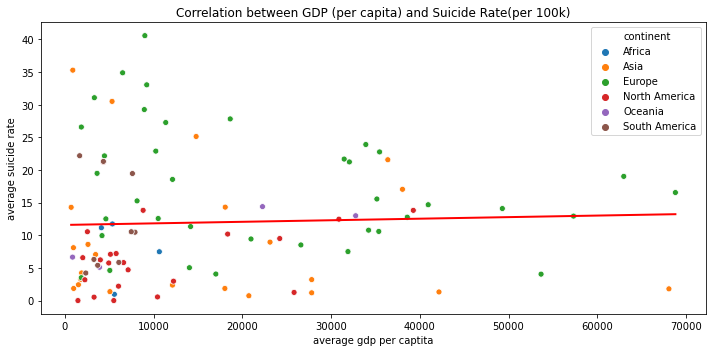

In [48]:
lm = LinearRegression()
X = gdp_suicide[['average gdp per captita']]
y = gdp_suicide['average suicide rate']
print(lm.fit(X, y))


# smallest and largest observed values
X_new = [[gdp_suicide['average gdp per captita'].min()], [
    gdp_suicide['average gdp per captita'].max()]]
pred = lm.predict(X_new)  # y value

# scatter plot
plt.subplots(figsize=(10, 5))
sns.scatterplot('average gdp per captita', 'average suicide rate',
                hue='continent', data=gdp_suicide)

# Then, plot the least squares line
plt.plot(X_new, pred, c='red', linewidth=2)
plt.title("Correlation between GDP (per capita) and Suicide Rate(per 100k)")
plt.tight_layout()

# print intercept and coefficients
print('intercept is ', str(round(lm.intercept_, 3)))
print('coefficient is ', str(np.round(lm.coef_, 3)[0]))

# calculate the R-squared
print('R-squared is ', str(round(lm.score(X, y), 3)))

**Insight**
* Each data point represents each country.  
* As we can see from the scatterplot, there is **no correlation between GDP(per capita) and Suicide Rate(per 100k)**. 
* The r-squared is 0.002, so **GDP (per capita) explains very little of the variance** in suicide rate overall.

# Feature engineering 

- ## Correlation Heatmap

**Insight**
* Use correlation heatmap to see how the variables correlated. 

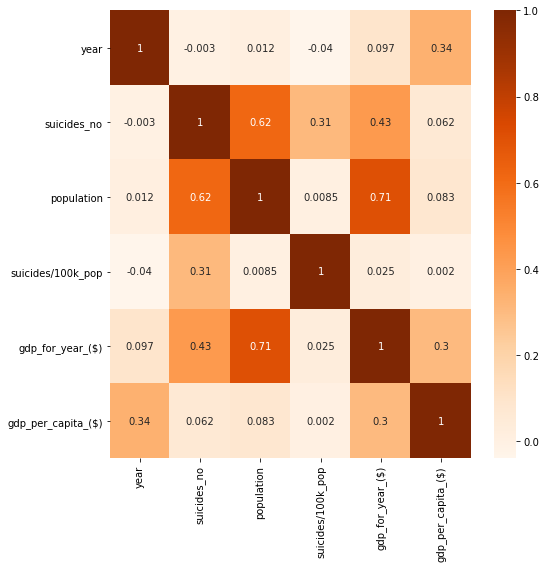

In [49]:
# Correlation heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(suicide_rate.corr(), annot=True, cmap='Oranges')
plt.tight_layout()

**Insight**

* from the heatmap above, we can see the correlation between **suicides_no** and **population** is **0.62** and the correlation between **gdp_for_year_($)** and **population** is **0.71**. They are correlated. **I consider values above 0.75 as highly correlated**. 

- ## Variance Inflation Factor(VIF)

* Check the muliticollinearity by another method **Variance Inflation Factor(VIF)**. It quantifies the severity of multicollinearity in an ordinary least squares regression analysis. VIF value can be interpreted as
    * **1 (Non-collinear)**
    * **1–5 (Medium collinear)**
    * **above 5 (Highly collinear)**

**Reference:https://towardsdatascience.com/https-towardsdatascience-com-multicollinearity-how-does-it-create-a-problem-72956a49058**

In [50]:
y = suicide_rate['suicides/100k_pop']

# drop categorical variables and target variabels
X = suicide_rate.drop(['suicides/100k_pop', 'age', 'sex',
                       'generation', 'country', 'continent'], axis=1)

vif = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif)

[3.7061880203700674e-05, 1.6128361422348907, 2.7496067463014806, 2.522691310795178, 1.1514370540633412]


In [51]:
print(list(X.columns.values))

['year', 'suicides_no', 'population', 'gdp_for_year_($)', 'gdp_per_capita_($)']


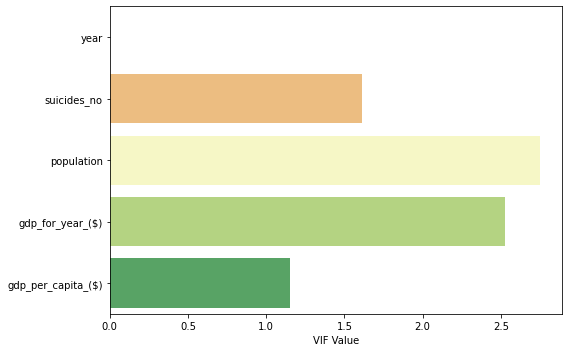

In [52]:
plt.figure(figsize=(8, 5))
sns.barplot(vif, list(X.columns.values), palette='RdYlGn', orient='h')
plt.xlabel("VIF Value")
plt.tight_layout()

**Insight**
* **All VIFs are below 5 (Medium collinear). Just like the result of correlation heatmap, they are correlated but not highly correlated. I will use mlxtend pacakge to do feature selection later.**

- ## Encoding Categorical Features 

* The **Age** feature has 6 unique age groups which needs to be encoded.
* **Sex** need be encoded.
* The **generation** feature has 6 types of generations which needs to be encoded as well.
* **country** and **continent** need be encoded. 

In [53]:
# encoding the categorical features using LabelEncoder

columns = ['age', 'sex', 'generation', 'country', 'continent']

for column in columns:
    suicide_rate[column] = sklearn.preprocessing.LabelEncoder(
    ).fit_transform(suicide_rate[column])

suicide_rate.head()

,country,year,sex,age,suicides_no,population,suicides/100k_pop,gdp_for_year_($),gdp_per_capita_($),generation,continent
0,0,1987,1,1,21,312900,6.71,2.156625e+09,796,2,2
1,0,1987,1,3,16,308000,5.19,2.156625e+09,796,5,2
2,0,1987,0,1,14,289700,4.83,2.156625e+09,796,2,2
3,0,1987,1,5,1,21800,4.59,2.156625e+09,796,1,2
4,0,1987,1,2,9,274300,3.28,2.156625e+09,796,0,2


- ## Feature Scaling 

In [54]:
# create X and y
scaler = StandardScaler()
X = suicide_rate.drop('suicides/100k_pop', axis=1)
X = scaler.fit_transform(X)
y = suicide_rate['suicides/100k_pop']

- ## Split The Data Into Train And Test sets

In [55]:
# Split the dataset into train and test sets: 80-20 split using the train_test_split method
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=12)

X_train.shape, X_test.shape

((22128, 10), (5532, 10))

# Methodology 


**Since the data used to train the algorithm is already labeled and target values are continuous. I am gonna use supervised machine learning regression algorithms on this data set.**

In [56]:
# Creating empty lists to store the model performance results
ML_Model = []
num_of_feature = []
rmse_Model = []

# Creating function to call for storing the results


def storeResults(model, a, b):
    ML_Model.append(model)
    num_of_feature.append(a)
    rmse_Model.append(round(b, 3))

- ## Linear Regression

- ### Include All Features 

In [57]:
# instantiate the model
lm = LinearRegression()

# fit the model
lm.fit(X_train, y_train)

print("R-squared with a single train/test split:", lm.score(X_test, y_test))
print("\n")
# Perform the training using KFolds cross validation method.
lr_score = cross_validate(lm, X, y, cv=10, scoring=[
                          'neg_root_mean_squared_error', 'r2'])
print(lr_score)

R-squared with a single train/test split: 0.36423069146217046


{'fit_time': array([0.02766705, 0.01660895, 0.02058005, 0.0323441 , 0.01268721,
       0.01225495, 0.01098132, 0.01460195, 0.01309609, 0.01335382]), 'score_time': array([0.00274396, 0.00159192, 0.00459695, 0.00206995, 0.00148773,
       0.00274515, 0.00143576, 0.00244713, 0.00178814, 0.00267196]), 'test_neg_root_mean_squared_error': array([-14.95750238, -15.42330662, -13.21790754, -14.87836725,
       -17.59205573, -19.251507  ,  -9.79675789, -17.46482909,
       -17.21949166, -13.36073774]), 'test_r2': array([0.04195777, 0.32212721, 0.36355703, 0.35490762, 0.33642083,
       0.24663002, 0.21110989, 0.44886937, 0.32994978, 0.30913114])}


In [58]:
# fix the sign of RMSE scores
rmse_scores = -lr_score['test_neg_root_mean_squared_error']
print(rmse_scores)

# calculate the average RMSE
print("Mean 10-Fold RMSE :", rmse_scores.mean())

# calculate r2
lr_r2_score = lr_score['test_r2']
print("Mean 10-Fold R Sqaured:", lr_r2_score.mean())

[14.95750238 15.42330662 13.21790754 14.87836725 17.59205573 19.251507
  9.79675789 17.46482909 17.21949166 13.36073774]
Mean 10-Fold RMSE : 15.316246290035043
Mean 10-Fold R Sqaured: 0.2964660669037282


In [59]:
# store the results by call the function storeResults
storeResults('Linear Regression with All features',
             X.shape[1], rmse_scores.mean())

**Insight**
* with all features linear regression model still has a poor performance since r2 score is relative low.
* the model explains 29.6% of the variability of the response data around its mean

- ### Sequential Forward Selection

**reference**: https://www.analyticsvidhya.com/blog/2020/10/a-comprehensive-guide-to-feature-selection-using-wrapper-methods-in-python/
https://www.kaggle.com/ar2017/basics-of-feature-selection-with-python

In [60]:
# Sequential Forward Selection(sfs)
sfs = SFS(LinearRegression(),
          k_features="best",  # Consider any feature combination between 1 and 10
          forward=True,
          floating=False,
          scoring='neg_root_mean_squared_error',
          cv=10)

sfs = sfs.fit(X, y)

# Transform the dataset
X_new = sfs.transform(X)

# Print the results
print('Number of features before transformation: ', X.shape[1])
print('Number of features after transformation: ', X_new.shape[1])
print('Best CV RMSE:', -sfs.k_score_)
# k_feature_idx_ shows the index of features
print('Best subset (indices):', sfs.k_feature_idx_)
# that yield the best score

print('Best subset (corresponding names):', sfs.k_feature_names_)

Number of features before transformation:  10
Number of features after transformation:  6
Best CV RMSE: 15.123533686641618
Best subset (indices): (1, 2, 3, 4, 5, 8)
Best subset (corresponding names): ('1', '2', '3', '4', '5', '8')


**Notice that features names doesn't correspond to the column name. Since the package said if pandas DataFrames are used in the `fit` method, the 'feature_names' correspond to the column names. Otherwise, the
feature names are string representation of the feature array indices. The 'feature_names' is new in v 0.13.0. https://github.com/rasbt/mlxtend/blob/master/mlxtend/feature_selection/sequential_feature_selector.py**

In [61]:
# best subset feature names
[suicide_rate.columns.values[i] for i in list(sfs.k_feature_idx_)]

['year', 'sex', 'age', 'suicides_no', 'population', 'gdp_per_capita_($)']

In [62]:
# Show the performance of each subset of features considered by SBS
sfs_results = pd.DataFrame.from_dict(sfs.subsets_).T
sfs_results

,feature_idx,cv_scores,avg_score,feature_names
1,"(2,)","[-15.81847472385578, -17.04586218768309, -15.1...",-17.2093,"(2,)"
2,"(2, 3)","[-15.377267352892884, -15.481035597148445, -13...",-15.8709,"(2, 3)"
3,"(2, 3, 4)","[-14.735079127460914, -15.357269005430522, -13...",-15.3961,"(2, 3, 4)"
4,"(2, 3, 4, 5)","[-14.851635101598749, -15.124930281865106, -13...",-15.1442,"(2, 3, 4, 5)"
5,"(1, 2, 3, 4, 5)","[-14.848730417241109, -15.07210969770958, -13....",-15.1299,"(1, 2, 3, 4, 5)"
6,"(1, 2, 3, 4, 5, 8)","[-14.842113608444018, -15.050656891611775, -13...",-15.1235,"(1, 2, 3, 4, 5, 8)"
7,"(1, 2, 3, 4, 5, 8, 9)","[-14.872766892079632, -15.013055395648353, -13...",-15.1403,"(1, 2, 3, 4, 5, 8, 9)"
8,"(1, 2, 3, 4, 5, 7, 8, 9)","[-14.93692934518319, -15.02026128858854, -13.1...",-15.1689,"(1, 2, 3, 4, 5, 7, 8, 9)"
9,"(1, 2, 3, 4, 5, 6, 7, 8, 9)","[-14.954402274093898, -15.113679387042112, -13...",-15.2166,"(1, 2, 3, 4, 5, 6, 7, 8, 9)"
10,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)","[-14.957502378999369, -15.423306618440566, -13...",-15.3162,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)"


In [63]:
# store the results by call the function storeResults
storeResults('Linear Regression after SFS', X_new.shape[1],  -sfs.k_score_)

**Insight**
* after forward selection, **the number of features reduces from 10 to 6**
* RMSE decrease from 15.32 to 15.12. **It improves model performance a little bit after forward selection.** 

- ### Sequential Backward Selection

In [64]:
# Sequential backward selection(sbs)
sbs = SFS(LinearRegression(),
          k_features="best",
          forward=False,
          floating=False,
          scoring='neg_root_mean_squared_error',
          cv=10)

sbs = sbs.fit(X, y)

# Transform the dataset
X_new = sbs.transform(X)

# Print the results
print('Number of features before transformation: ', X.shape[1])
print('Number of features after transformation: ', X_new.shape[1])
print('Best CV RMSE:', -sbs.k_score_)   # k_score_ shows the best score
# k_feature_idx_ shows the index of features
print('Best subset (indices):', sbs.k_feature_idx_)
# k_feature_names_ shows the feature names
print('Best subset (corresponding names):', sbs.k_feature_names_)

Number of features before transformation:  10
Number of features after transformation:  6
Best CV RMSE: 15.123533686641618
Best subset (indices): (1, 2, 3, 4, 5, 8)
Best subset (corresponding names): ('1', '2', '3', '4', '5', '8')


In [65]:
# best subset feature names
[suicide_rate.columns.values[i] for i in list(sfs.k_feature_idx_)]

['year', 'sex', 'age', 'suicides_no', 'population', 'gdp_per_capita_($)']

In [66]:
# Show the performance of each subset of features considered by SBS
sbs_results = pd.DataFrame.from_dict(sbs.subsets_).T
sbs_results

,feature_idx,cv_scores,avg_score,feature_names
10,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)","[-14.957502378999369, -15.423306618440566, -13...",-15.3162,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)"
9,"(1, 2, 3, 4, 5, 6, 7, 8, 9)","[-14.954402274093898, -15.113679387042112, -13...",-15.2166,"(1, 2, 3, 4, 5, 6, 7, 8, 9)"
8,"(1, 2, 3, 4, 5, 7, 8, 9)","[-14.93692934518319, -15.02026128858854, -13.1...",-15.1689,"(1, 2, 3, 4, 5, 7, 8, 9)"
7,"(1, 2, 3, 4, 5, 8, 9)","[-14.872766892079632, -15.013055395648353, -13...",-15.1403,"(1, 2, 3, 4, 5, 8, 9)"
6,"(1, 2, 3, 4, 5, 8)","[-14.842113608444018, -15.050656891611775, -13...",-15.1235,"(1, 2, 3, 4, 5, 8)"
5,"(1, 2, 3, 4, 5)","[-14.848730417241109, -15.07210969770958, -13....",-15.1299,"(1, 2, 3, 4, 5)"
4,"(2, 3, 4, 5)","[-14.851635101598749, -15.124930281865106, -13...",-15.1442,"(2, 3, 4, 5)"
3,"(2, 3, 4)","[-14.735079127460914, -15.357269005430522, -13...",-15.3961,"(2, 3, 4)"
2,"(2, 3)","[-15.377267352892884, -15.481035597148445, -13...",-15.8709,"(2, 3)"
1,"(2,)","[-15.81847472385578, -17.04586218768309, -15.1...",-17.2093,"(2,)"


In [67]:
# store the results by call the function storeResults
storeResults('Linear Regression after SBS', X_new.shape[1], -sbs.k_score_)

**Insight**
* Backword Selction gives the same result with Forward Selection.
* The number of features **reduces from 10 to 6**
* RMSE decrease from 15.32 to 15.12. **It improves model performance a little bit after backward selection.** 

- ## K-Nearest Neighbors(KNN)

- ### Get The Best K

In [68]:
# instantiate KNN Regression model
knn = KNeighborsRegressor()
param_grid = {'n_neighbors': list(range(1, 31)), 'weights': [
    'uniform', 'distance']}

# instantiate the grid
knn_grid = GridSearchCV(knn, param_grid, cv=10)

# fit the model
knn_grid.fit(X_train, y_train)

# best parameters for KNN model
print(knn_grid.best_params_)

{'n_neighbors': 3, 'weights': 'distance'}


**Insight**
* the best k is 3 and based on distance weights. 

- ### Include All Features

In [69]:
# use the same model as before but choose k = 3, weights = 'distance'
knn = KNeighborsRegressor(n_neighbors=3, weights='distance')

# 10 fold cross validation
knn_score = cross_validate(knn, X, y, cv=10, scoring=[
                           'neg_root_mean_squared_error', 'r2'])

# print all 10 times scores
print(knn_score)

{'fit_time': array([0.03299499, 0.022048  , 0.02154207, 0.01996493, 0.02420402,
       0.02088118, 0.07515168, 0.02060103, 0.02453017, 0.02436185]), 'score_time': array([0.39215684, 0.17044616, 0.18387604, 0.19745708, 0.20864296,
       0.30948806, 0.24438214, 0.17705512, 0.18769217, 0.15441394]), 'test_neg_root_mean_squared_error': array([-15.261333  , -11.59413909, -14.31483281, -14.70169252,
       -17.14806909, -18.94025357, -13.69357767, -17.70089687,
       -18.74000234, -16.53329339]), 'test_r2': array([ 0.00264119,  0.61693698,  0.25353984,  0.3701371 ,  0.36949286,
        0.27079368, -0.54129446,  0.43386968,  0.2063921 , -0.0579216 ])}


In [70]:
# fix the sign of RMSE scores
knn_rmse_scores = -knn_score['test_neg_root_mean_squared_error']
print(knn_rmse_scores)

# calculate the average RMSE
print("Mean 10-Fold RMSE :", knn_rmse_scores.mean())


# calculate r2
knn_r2_score = knn_score['test_r2']
print("Mean 10-Fold R Squared:", knn_r2_score.mean())

[15.261333   11.59413909 14.31483281 14.70169252 17.14806909 18.94025357
 13.69357767 17.70089687 18.74000234 16.53329339]
Mean 10-Fold RMSE : 15.862809035129198
Mean 10-Fold R Squared: 0.1924587363067068


In [71]:
# store the results by call the function storeResults
storeResults('knn with all features', X.shape[1], knn_rmse_scores.mean())

**Insight**
* with all features KNN model still has a poor performance since r2 score is relative low.
* the model explains 19.2% of the variability of the response data around its mean.

- ### Sequential Forward Selection

In [72]:
# build KNN regression model
knn = KNeighborsRegressor(n_neighbors=3, weights='distance')

# Sequential Forward Selection(sfs)
sfs = SFS(knn,
          k_features="best",  # Consider any feature combination between 1 and 10
          forward=True,
          floating=False,
          scoring='neg_root_mean_squared_error',
          cv=10)

sfs = sfs.fit(X, y)

# Transform the dataset
X_new = sfs.transform(X)

# Print the results
print('Number of features before transformation: ', X.shape[1])
print('Number of features after transformation: ', X_new.shape[1])
print('Best CV RMSE:', -sfs.k_score_) # k_score_ shows the best score
print('Best subset (indices):', sfs.k_feature_idx_) # k_feature_idx_ shows the index of features
print('Best subset (corresponding names):', sfs.k_feature_names_) # k_feature_names_ shows the feature names

Number of features before transformation:  10
Number of features after transformation:  2
Best CV RMSE: 2.6570478505247075
Best subset (indices): (4, 5)
Best subset (corresponding names): ('4', '5')


In [73]:
# best subset feature names
[suicide_rate.columns.values[i] for i in list(sfs.k_feature_idx_)]

['suicides_no', 'population']

In [74]:
# Show the performance of each subset of features considered by SBS
sfs_results = pd.DataFrame.from_dict(sfs.subsets_).T
sfs_results

,feature_idx,cv_scores,avg_score,feature_names
1,"(4,)","[-14.640800659161751, -19.76452466122684, -17....",-19.3184,"(4,)"
2,"(4, 5)","[-1.1141834568488636, -1.0102957013973188, -1....",-2.65705,"(4, 5)"
3,"(2, 4, 5)","[-1.8508260569427282, -1.1628951125344555, -1....",-2.951,"(2, 4, 5)"
4,"(2, 3, 4, 5)","[-2.1458893493287796, -2.3718453713606302, -2....",-4.42529,"(2, 3, 4, 5)"
5,"(2, 3, 4, 5, 8)","[-3.7544722477697774, -3.654734247892253, -2.6...",-5.55242,"(2, 3, 4, 5, 8)"
6,"(2, 3, 4, 5, 6, 8)","[-5.654207887174996, -5.586549222409606, -4.50...",-7.18705,"(2, 3, 4, 5, 6, 8)"
7,"(1, 2, 3, 4, 5, 6, 8)","[-7.772781006615936, -6.99190702464958, -5.132...",-9.19984,"(1, 2, 3, 4, 5, 6, 8)"
8,"(1, 2, 3, 4, 5, 6, 8, 9)","[-9.346191531192062, -8.331308001105764, -10.7...",-11.912,"(1, 2, 3, 4, 5, 6, 8, 9)"
9,"(1, 2, 3, 4, 5, 6, 7, 8, 9)","[-13.535915421261912, -11.054681360754815, -13...",-14.5683,"(1, 2, 3, 4, 5, 6, 7, 8, 9)"
10,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)","[-15.261332995372143, -11.594139085470813, -14...",-15.8628,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)"


In [75]:
# store the results by call the function storeResults
storeResults('knn after SFS', X_new.shape[1], -sfs.k_score_)

**Insight**
* after forward selection, **the number of features reduces from 10 to 2**
* RMSE decrease from 15.86 to 2.66. **It improves model performance a lot after forward selection.** 

- ### Sequential Backward Selection

In [76]:
# build KNN regression model
knn = KNeighborsRegressor(n_neighbors=3, weights='distance')

# sequential backward selection(sbs)
sbs = SFS(knn,
          k_features="best",
          forward=False,
          floating=False,
          scoring='neg_root_mean_squared_error',
          cv=10)

sbs = sbs.fit(X, y)

# Transform the dataset
X_new = sbs.transform(X)

# Print the results
print('Number of features before transformation: ', X.shape[1])
print('Number of features after transformation: ', X_new.shape[1])
print('Best CV RMSE:', -sbs.k_score_)   # k_score_ shows the best score                                              
print('Best subset (indices):', sbs.k_feature_idx_) # k_feature_idx_ shows the index of features   
print('Best subset (corresponding names):', sbs.k_feature_names_) # k_feature_names_ shows the feature names

Number of features before transformation:  10
Number of features after transformation:  2
Best CV RMSE: 2.6570478505247075
Best subset (indices): (4, 5)
Best subset (corresponding names): ('4', '5')


In [77]:
# best subset feature names
[suicide_rate.columns.values[i] for i in list(sfs.k_feature_idx_)]

['suicides_no', 'population']

In [78]:
# Show the performance of each subset of features considered by SBS
sbs_results = pd.DataFrame.from_dict(sbs.subsets_).T
sbs_results

,feature_idx,cv_scores,avg_score,feature_names
10,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)","[-15.261332995372143, -11.594139085470813, -14...",-15.8628,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)"
9,"(1, 2, 3, 4, 5, 6, 7, 8, 9)","[-13.535915421261912, -11.054681360754815, -13...",-14.5683,"(1, 2, 3, 4, 5, 6, 7, 8, 9)"
8,"(1, 2, 3, 4, 5, 6, 8, 9)","[-9.346191531192062, -8.331308001105764, -10.7...",-11.912,"(1, 2, 3, 4, 5, 6, 8, 9)"
7,"(1, 2, 3, 4, 5, 6, 8)","[-7.772781006615936, -6.99190702464958, -5.132...",-9.19984,"(1, 2, 3, 4, 5, 6, 8)"
6,"(2, 3, 4, 5, 6, 8)","[-5.654207887174996, -5.586549222409606, -4.50...",-7.18705,"(2, 3, 4, 5, 6, 8)"
5,"(2, 3, 4, 5, 8)","[-3.7544722477697774, -3.654734247892253, -2.6...",-5.55242,"(2, 3, 4, 5, 8)"
4,"(2, 3, 4, 5)","[-2.1458893493287796, -2.3718453713606302, -2....",-4.42529,"(2, 3, 4, 5)"
3,"(2, 4, 5)","[-1.8508260569427282, -1.1628951125344555, -1....",-2.951,"(2, 4, 5)"
2,"(4, 5)","[-1.1141834568488636, -1.0102957013973188, -1....",-2.65705,"(4, 5)"
1,"(4,)","[-14.640800659161751, -19.76452466122684, -17....",-19.3184,"(4,)"


In [79]:
storeResults('knn after SBS', X_new.shape[1], -sbs.k_score_)

**Insight**
* Backword Selction gives the same result with Forward Selection.
* after backward selection, **the number of features reduces from 10 to 2**
* RMSE decrease from 15.86 to 2.66. **It improves model performance a lot after backward selection.** 

In [80]:
# Comparison Of Models
results = pd.DataFrame({'ML Model': ML_Model,
                        'Number of Features': num_of_feature,
                        'Cross Validation RMSE': rmse_Model,
                        })
print(results)

                              ML Model  Number of Features  \
0  Linear Regression with All features                  10   
1          Linear Regression after SFS                   6   
2          Linear Regression after SBS                   6   
3                knn with all features                  10   
4                        knn after SFS                   2   
5                        knn after SBS                   2   

   Cross Validation RMSE  
0                 15.316  
1                 15.124  
2                 15.124  
3                 15.863  
4                  2.657  
5                  2.657  


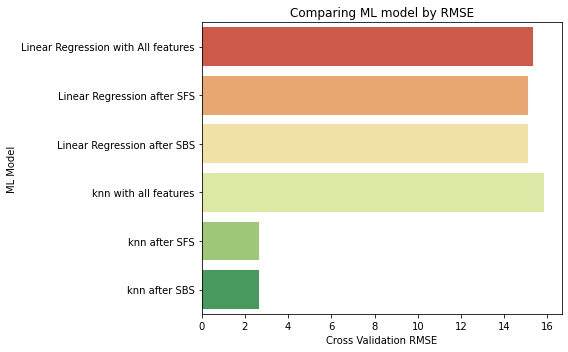

In [81]:
plt.figure(figsize=(8, 5))
sns.barplot('Cross Validation RMSE', 'ML Model', orient='h', palette='RdYlGn', data=results)
plt.title("Comparing ML model by RMSE")
plt.tight_layout()

In [82]:
sbs = SFS(knn,
          k_features="best",
          forward=False,
          floating=False,
          scoring='r2',
          cv=10)
sbs = sbs.fit(X, y)

# Transform the dataset
X_new = sbs.transform(X)

# Print the results
print('Number of features before transformation: ', X.shape[1])
print('Number of features after transformation: ', X_new.shape[1])
print('Best CV R squared:', sbs.k_score_)   # k_score_ shows the best score                                              
print('Best subset (indices):', sbs.k_feature_idx_) # k_feature_idx_ shows the index of features   
print('Best subset (corresponding names):', sbs.k_feature_names_) # k_feature_names_ shows the feature names

Number of features before transformation:  10
Number of features after transformation:  2
Best CV R squared: 0.9750607596026762
Best subset (indices): (4, 5)
Best subset (corresponding names): ('4', '5')


**Insight**

* By comparing **RMSE** between Linear regression and knn **with all feautres included, Linear Regression Model predicts slightly better than KNN**. 
* **After feature selection, KNN model with 2 features (suicide_no and population) predicts better than linear regression model with 6 features, which decreases RMSE from 15.12 to 2.66**. 
* **After feature selection, KNN model with 2 features (suicide_no and population) explains 97.5% of the variability of the response data around its mean**.

# Conclusions

The final conclusion on the suicide dataset are that **male are more prone to commit suicide than female**. By creating this notebook, I am more familiar with different packages and their function parameters and improve Python programming skill as well as problem solving skill. The challenge I met is that when I tried to use jupyter magic command **%matplotlib widget** to create interactive plots, when I closed the notebook and opened it again the output plots were all empty and need to rerun again to bring the plots back. And I tried to open it in another IDE like VS code, all plots lose interactivity. So I use static plots instead. This project can extended to include more ML algorithms and can be modified to classification task, like classifying countries to 3 groups based on their suicide rate (high suicide rate, medium suicide rate, low suicide rate). Also, geomap can be used in this project as well.  